In [ ]:
import torch
import torchvision.datasets as datasets
import  torchvision.transforms as tt
from random import randint
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import transforms
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
train = datasets.MNIST(root='./data',train=True,download=True)
test_ds = datasets.MNIST(root='./data',train=False,download=True,transform = tt.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
test_ds

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
val_size = int(len(train)*0.2)
train_size = len(train)-val_size
train1=int(train_size*0.2)
train2=train_size-train1

train1_ds,train2_ds, val_ds  = torch.utils.data.random_split(train, [train1,train2,val_size])


print(len(train1_ds),len(train2_ds), len(val_ds))

9600 38400 12000


In [ ]:
batch = 256

In [ ]:
class ImageDataset():
    def __init__(self, data,transform=None):
        self.data=data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
class RModel(nn.Module):
  def __init__(self,pool=nn.MaxPool2d,active=nn.ReLU):
    super().__init__()

    self.conv1 = nn.Sequential(nn.Conv2d( 1, 10, kernel_size = 5, padding = 1, stride=1),pool(2, 2),active()) #10*13*13

    self.conv2 = nn.Sequential(nn.Conv2d( 10, 20, kernel_size = 2, padding = 8, stride=1),active()) #20*6*6
    
    
    self.pool = pool(2,2)#20*3*3
    self.flat = nn.Flatten()
    self.n50 = nn.Linear(20*14*14,50)
    self.act = active()
    self.head = nn.Linear(50,10)
    self.final = nn.LogSoftmax()
    
    self.train_loss = 0
    

  def forward(self, x):
    residue = x
    x = self.conv1(x)
    x = self.conv2(x)+residue
    x = self.pool(x)
    
    x = self.flat(x)
    
    x = self.act(x)
    
    
    x = self.n50(x)
    x = self.head(x)
    x = self.final(x)
    return x
  def train_step(self,batch):
      
      image , label =  batch
      pred = self(image)
      loss = F.cross_entropy(pred,label)
      
      train_acc = accuracy(pred,label)
      return loss, train_acc
    
  def valid_step(self,batch):
      image , label =  batch
      pred = self(image)
      loss = F.cross_entropy(pred,label)
      val_acc = accuracy(pred,label)
      return {'val_loss':loss.item(), 'val_acc':val_acc}





In [ ]:
@torch.no_grad()
def accuracy(outputs,label):
  _,out = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)

def accumalter(result):
  val_loss = [i['val_loss'] for i in result]
  val_acc = [i['val_acc'] for i in result]
  val_loss = np.mean(val_loss)
  val_acc = np.mean(val_acc)
  return {'val_loss':val_loss, 'val_acc':val_acc}

@torch.no_grad()
def valid_fun(model,val_dl):
  model.eval()
  result = [model.valid_step(i) for i in val_dl]
  return accumalter(result)

def fit(model,train_dl,val_dl,epochs,lr,optim):
  optimizer = optim(model.parameters(),lr=lr)
  history = []
  for epoch in range(epochs):
    train_loss = []
    train_acc = []
    model.train()
    for batch in tqdm(train_dl):
      optimizer.zero_grad()
      loss,acc = model.train_step(batch)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      train_acc.append(acc)
    result = valid_fun(model,val_dl)
    result['train_loss']=np.mean(train_loss)
    result['train_acc']=np.mean(train_acc)
    history.append(result)
    print(f'epoch :{epoch+1}, training loss: {result["train_loss"]},training accuracy: {result["train_acc"]}, validation loss: {result["val_loss"]}, valid accuracy: {result["val_acc"]}')
  return history
    




In [ ]:
def plot_loss(meta):
  val_loss = [i['val_loss'] for i in meta]
  train_loss = [i['train_loss'] for i in meta]
  plt.plot(range(len(meta)),train_loss,label='train_loss')
  plt.plot(range(len(meta)),val_loss,label='validation_loss')
  plt.title("Training loss Vs Validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Cross Entopy loss")
  plt.legend()
  plt.show()
def plot_acc(meta):
  val_acc = [i['val_acc'] for i in meta]
  train_acc = [i['train_acc'] for i in meta]
  plt.plot(range(len(meta)),train_acc,label='train_accuracy')
  plt.plot(range(len(meta)),val_acc,label='validation_accuracy')
  plt.title("Training Accuracy Vs Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


In [ ]:
def accuracy_model():
  model.eval()
  acc= 0
  for i,j in test_dl:
    pred = model(i)
    acc += accuracy(pred,j)
  print(f'accuracy for model {k}  on test set is {acc/len(test_dl)}')

## a)

In [ ]:
# make transformer to tranforms dataset
transformer_train = transforms.Compose([
    transforms.ToTensor(),# convert into tensor
    transforms.RandomCrop(28,padding=3,padding_mode='reflect'), # apply  random Crop with padding and padding mode is reflect
     
])

transformer = transforms.Compose([
    transforms.ToTensor(), # convert into tensor
])

In [ ]:
train1_dataset=ImageDataset(train1_ds,transformer_train)
train2_dataset=ImageDataset(train2_ds,transformer)
val_dataset=ImageDataset(val_ds,transformer)
train_dataset = torch.utils.data.ConcatDataset([train1_dataset, train2_dataset])
print(len(train_dataset), len(val_dataset))

48000 12000


In [ ]:

train_dl = torch.utils.data.DataLoader ( train_dataset,batch, shuffle=True)
val_dl = torch.utils.data.DataLoader ( val_dataset,batch, shuffle=True)
test_dl = torch.utils.data.DataLoader ( test_ds,batch, shuffle=True)

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-7-d4ca8f19088e>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-8-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 0.987965833316458,training accuracy: 0.770985704787234, validation loss: 0.4144933172997008, valid accuracy: 0.8778020516717325


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.6123091951012611,training accuracy: 0.8257770944148937, validation loss: 0.40380343224139925, valid accuracy: 0.8833824088145897


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.6116579431802669,training accuracy: 0.8265666555851063, validation loss: 0.39116980737828194, valid accuracy: 0.8859351253799392


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.6057328248911715,training accuracy: 0.8259017619680851, validation loss: 0.3959717649094602, valid accuracy: 0.8818745250759878


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.6152045725190893,training accuracy: 0.8251745345744681, validation loss: 0.4045648283146797, valid accuracy: 0.8863269376899695


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.6173301711678505,training accuracy: 0.825943317819149, validation loss: 0.42755022962042627, valid accuracy: 0.8694196428571429


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.6139537500257187,training accuracy: 0.8249044215425532, validation loss: 0.40825835884885586, valid accuracy: 0.8780513867781156


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.6192455898891104,training accuracy: 0.823491522606383, validation loss: 0.4090181310126122, valid accuracy: 0.8878823138297872


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.6176453487987213,training accuracy: 0.8264419880319149, validation loss: 0.42864345616482674, valid accuracy: 0.8771015387537994


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.6149916950058429,training accuracy: 0.8261510970744681, validation loss: 0.40574582333260395, valid accuracy: 0.8859351253799392


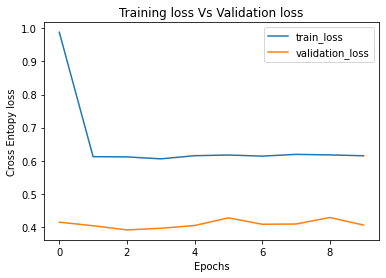

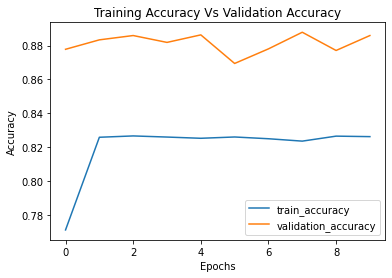

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model_a')

## b)

In [ ]:
# make transformer to tranforms dataset
transformer_train = transforms.Compose([
    transforms.ToTensor(),# convert into tensor
    transforms.RandomHorizontalFlip()# left right flip the dataset
     
])

transformer = transforms.Compose([
    transforms.ToTensor(), # convert into tensor
])

In [ ]:
train1_dataset=ImageDataset(train1_ds,transformer_train)
train2_dataset=ImageDataset(train2_ds,transformer)
val_dataset=ImageDataset(val_ds,transformer)
train_dataset = torch.utils.data.ConcatDataset([train1_dataset, train2_dataset])
print(len(train_dataset), len(val_dataset))

48000 12000


In [ ]:

train_dl = torch.utils.data.DataLoader ( train_dataset,batch, shuffle=True)
val_dl = torch.utils.data.DataLoader ( val_dataset,batch, shuffle=True)
test_dl = torch.utils.data.DataLoader ( test_ds,batch, shuffle=True)

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-7-d4ca8f19088e>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-8-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 0.583025280465471,training accuracy: 0.8328831449468085, validation loss: 0.42268031708737636, valid accuracy: 0.8725897606382979


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.475462832190889,training accuracy: 0.858169880319149, validation loss: 0.44767251547346726, valid accuracy: 0.8709037803951368


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.4799571268736048,training accuracy: 0.8548454122340425, validation loss: 0.44371789186558824, valid accuracy: 0.8669975303951368


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.47180422443024655,training accuracy: 0.8583776595744681, validation loss: 0.4355035443255242, valid accuracy: 0.8727441109422492


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.4632005737499988,training accuracy: 0.861556682180851, validation loss: 0.41266459416835866, valid accuracy: 0.879404920212766


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.4643464208917415,training accuracy: 0.8617644614361702, validation loss: 0.4092958040059881, valid accuracy: 0.878205737082067


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.4613236811883906,training accuracy: 0.8614943484042553, validation loss: 0.43200071631593906, valid accuracy: 0.87647226443769


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.46572713633166984,training accuracy: 0.8624085771276596, validation loss: 0.4258823921071722, valid accuracy: 0.8713905775075989


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.4531845209446359,training accuracy: 0.862803357712766, validation loss: 0.41675047481313665, valid accuracy: 0.8787637727963525


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.45014809341506756,training accuracy: 0.8657746010638298, validation loss: 0.41615840348791566, valid accuracy: 0.8731715425531915


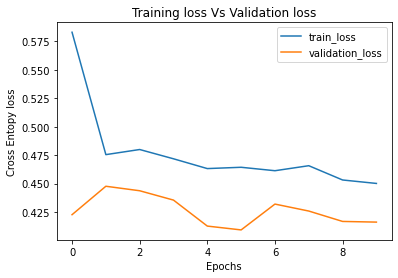

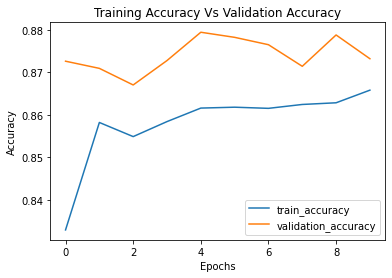

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model_b')

## c)

In [ ]:
# make transformer to tranforms dataset
transformer_train = transforms.Compose([
    transforms.ToTensor(),# convert into tensor
    transforms.RandomRotation(degrees=20)# random rotation the dataset
     
])

transformer = transforms.Compose([
    transforms.ToTensor(), # convert into tensor
])

In [ ]:
train1_dataset=ImageDataset(train1_ds,transformer_train)
train2_dataset=ImageDataset(train2_ds,transformer)
val_dataset=ImageDataset(val_ds,transformer)
train_dataset = torch.utils.data.ConcatDataset([train1_dataset, train2_dataset])
print(len(train_dataset), len(val_dataset))

48000 12000


In [ ]:

train_dl = torch.utils.data.DataLoader ( train_dataset,batch, shuffle=True)
val_dl = torch.utils.data.DataLoader ( val_dataset,batch, shuffle=True)
test_dl = torch.utils.data.DataLoader ( test_ds,batch, shuffle=True)

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-7-d4ca8f19088e>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-8-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 0.6050089040493711,training accuracy: 0.8426695478723404, validation loss: 0.386225163936615, valid accuracy: 0.8875854863221884


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.3790573013272691,training accuracy: 0.8885472074468085, validation loss: 0.3535069702787602, valid accuracy: 0.9009902165653496


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.3716638909375414,training accuracy: 0.8901678856382979, validation loss: 0.40199617026968204, valid accuracy: 0.8805447378419453


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.38121196350201647,training accuracy: 0.8868018617021277, validation loss: 0.32511514171640926, valid accuracy: 0.9038278875379939


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.2385438936663435,training accuracy: 0.9296251662234043, validation loss: 0.18609668409570734, valid accuracy: 0.9443863981762918


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.1710473367587683,training accuracy: 0.94921875, validation loss: 0.15037980453765137, valid accuracy: 0.9547278685410334


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.1615217427148464,training accuracy: 0.9509848736702128, validation loss: 0.1626311204534896, valid accuracy: 0.9531843655015197


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.16851047787101978,training accuracy: 0.9503407579787234, validation loss: 0.1475625122164158, valid accuracy: 0.9540273556231004


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.1598874930133845,training accuracy: 0.9523146609042553, validation loss: 0.1736663966736895, valid accuracy: 0.9453599924012158


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.15643576550436147,training accuracy: 0.9539768949468085, validation loss: 0.1792932745624096, valid accuracy: 0.9472953077507599


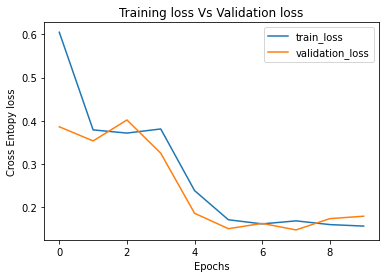

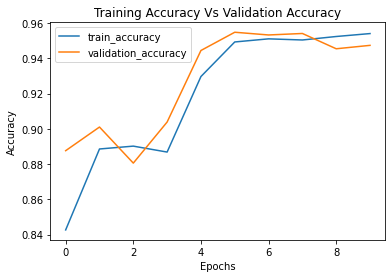

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model_c')

## d)

In [ ]:
# make transformer to tranforms dataset
transformer_train = transforms.Compose([
    transforms.ToTensor(),# convert into tensor
    transforms.GaussianBlur((5,9))# gaussian noise the dataset
     
])

transformer = transforms.Compose([
    transforms.ToTensor(), # convert into tensor
])

In [ ]:
train1_dataset=ImageDataset(train1_ds,transformer_train)
train2_dataset=ImageDataset(train2_ds,transformer)
val_dataset=ImageDataset(val_ds,transformer)
train_dataset = torch.utils.data.ConcatDataset([train1_dataset, train2_dataset])
print(len(train_dataset), len(val_dataset))

48000 12000


In [ ]:

train_dl = torch.utils.data.DataLoader ( train_dataset,batch, shuffle=True)
val_dl = torch.utils.data.DataLoader ( val_dataset,batch, shuffle=True)
test_dl = torch.utils.data.DataLoader ( test_ds,batch, shuffle=True)

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-7-d4ca8f19088e>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-8-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 0.6141387867800733,training accuracy: 0.850357380319149, validation loss: 0.3645283262780372, valid accuracy: 0.8949943009118542


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.3557572479736298,training accuracy: 0.8964635970744681, validation loss: 0.4257848395946178, valid accuracy: 0.8755936550151976


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.35306312500479375,training accuracy: 0.8973362699468085, validation loss: 0.392627219570444, valid accuracy: 0.8886303191489362


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.34496259205835933,training accuracy: 0.900639960106383, validation loss: 0.37070112405939304, valid accuracy: 0.8982831496960486


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.3515473668404082,training accuracy: 0.899185505319149, validation loss: 0.3704712650877364, valid accuracy: 0.8917766907294833


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.3540327027440071,training accuracy: 0.8976687167553191, validation loss: 0.37780893641583463, valid accuracy: 0.8943650265957447


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.36015263493073746,training accuracy: 0.8948429188829787, validation loss: 0.3796739286564766, valid accuracy: 0.8932370820668692


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.36006352083480103,training accuracy: 0.8970661569148937, validation loss: 0.3840111126290991, valid accuracy: 0.8946737272036475


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.3603298886025206,training accuracy: 0.8971077127659575, validation loss: 0.3943066822087511, valid accuracy: 0.8919310410334347


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.36434530736284054,training accuracy: 0.8944481382978723, validation loss: 0.3637985992938914, valid accuracy: 0.8962765957446809


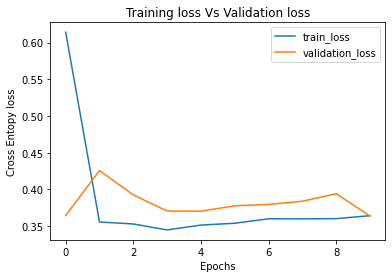

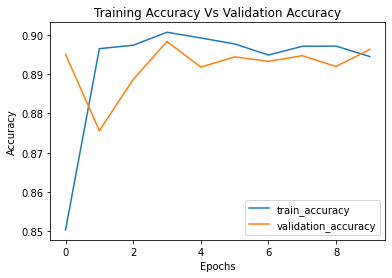

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model_d')

## e)

In [ ]:
# make transformer to tranforms dataset
transformer_train = transforms.Compose([
    transforms.ToTensor(),# convert into tensor
    transforms.RandomCrop(28,padding=3,padding_mode='reflect'), # apply  random Crop with padding and padding mode is reflect
    transforms.GaussianBlur((5,9)),# gaussian noise the dataset
    transforms.RandomRotation(degrees=20),# random rotation the dataset
    transforms.RandomHorizontalFlip()# left right flip the dataset

])

transformer = transforms.Compose([
    transforms.ToTensor(), # convert into tensor
])

In [ ]:
train1_dataset=ImageDataset(train1_ds,transformer_train)
train2_dataset=ImageDataset(train2_ds,transformer)
val_dataset=ImageDataset(val_ds,transformer)
train_dataset = torch.utils.data.ConcatDataset([train1_dataset, train2_dataset])
print(len(train_dataset), len(val_dataset))

48000 12000


In [ ]:

train_dl = torch.utils.data.DataLoader ( train_dataset,batch, shuffle=True)
val_dl = torch.utils.data.DataLoader ( val_dataset,batch, shuffle=True)
test_dl = torch.utils.data.DataLoader ( test_ds,batch, shuffle=True)

  0%|          | 0/188 [00:00<?, ?it/s]

<ipython-input-7-d4ca8f19088e>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-8-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


epoch :1, training loss: 1.0284345023175503,training accuracy: 0.7382189162234043, validation loss: 0.35197053881401713, valid accuracy: 0.9031511208206687


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :2, training loss: 0.48614624427988173,training accuracy: 0.855718085106383, validation loss: 0.21739146240214083, valid accuracy: 0.9315159574468085


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :3, training loss: 0.4087472529487407,training accuracy: 0.8766414561170213, validation loss: 0.20031190520905434, valid accuracy: 0.9378799392097265


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :4, training loss: 0.3846458084088691,training accuracy: 0.8822930518617021, validation loss: 0.19149988699466625, valid accuracy: 0.9421898746200608


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :5, training loss: 0.39103312433717097,training accuracy: 0.8819606050531915, validation loss: 0.17720095543785297, valid accuracy: 0.947247815349544


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :6, training loss: 0.37439950951870454,training accuracy: 0.8868018617021277, validation loss: 0.18063491519461286, valid accuracy: 0.9413112651975684


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :7, training loss: 0.3808727427682978,training accuracy: 0.8829995013297872, validation loss: 0.18642672373259322, valid accuracy: 0.9415131079027356


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :8, training loss: 0.3794683376525311,training accuracy: 0.8849734042553191, validation loss: 0.15908399573031892, valid accuracy: 0.9510234612462006


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :9, training loss: 0.38577080716161016,training accuracy: 0.8821476063829787, validation loss: 0.1887820840198943, valid accuracy: 0.9426647986322189


  0%|          | 0/188 [00:00<?, ?it/s]

epoch :10, training loss: 0.37266704162701647,training accuracy: 0.8854720744680851, validation loss: 0.15141680361108578, valid accuracy: 0.9504298062310031


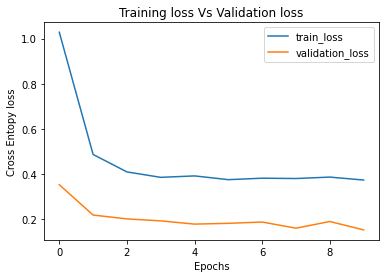

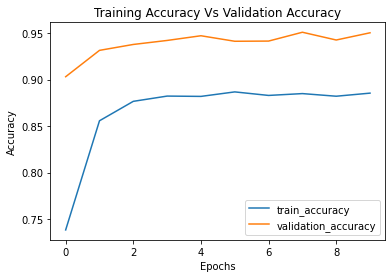

In [ ]:
activation_fn = nn.ReLU
Pooling_fn = nn.MaxPool2d
optim= torch.optim.Adam

model =  RModel(Pooling_fn,activation_fn)
epochs=10
lr=0.008
meta = fit(model,train_dl,val_dl,epochs,lr,optim)
plot_loss(meta)
plot_acc(meta)
torch.save(model.state_dict(), '/content/model_e')

## Test Accuracy

In [ ]:
model = RModel()  
k='a'
model.load_state_dict(torch.load('/content/model_'+str(k)))
accuracy_model()

model = RModel()
k='b'
model.load_state_dict(torch.load('/content/model_'+str(k)))
accuracy_model()

model = RModel()
k='c'
model.load_state_dict(torch.load('/content/model_'+str(k)))
accuracy_model()

model = RModel()
k='d'
model.load_state_dict(torch.load('/content/model_'+str(k)))
accuracy_model()

model = RModel()
k='e'
model.load_state_dict(torch.load('/content/model_'+str(k)))
accuracy_model()


<ipython-input-7-d4ca8f19088e>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.final(x)
<ipython-input-35-5a9a1dd14840>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(out == label).clone().detach()).item()/len(out)


accuracy for model a  on test set is 0.896875
accuracy for model b  on test set is 0.88330078125
accuracy for model c  on test set is 0.9541015625
accuracy for model d  on test set is 0.90283203125
accuracy for model e  on test set is 0.95712890625
